# Messing with power laws
R. Tagg  20-Feb-2022

## Power laws and critical exponents

Critical phenomena and certain types of bifurcations are characterized by a change in state at a critical value $\mu_c$ of a control parameter $\mu$, where some measure $y$ of a mode amplitude or an "order parameter" starts to grow according to a power law relationship:

$$y = Y_0|\mu-\mu_c|^\beta.$$

Taking the log (base 10) of both sides :

$$\log_{10}y = \log_{10}Y_0 + \beta\log_{10}|\mu-\mu_c|.$$

Suppose we make a series of measurements {$y_i$} for various values {$\mu_i$}. If we have previously measured the critical value $\mu_c$ then, in principle, we can find the critical exponent $\beta$ and the amplitude factor $Y_0$ by doing a linear fit of $\log_{10}y_i$ to values of $\log_{10}|\mu_i-\mu_c|$. The slope of the fit gives $\beta$ and the intercept gives $\log_{10}Y_0$.

We want to understand the effect of uncertainties in the data {$y_i$} and the critical point $\mu_c$ on the estimates for the exponent $\beta$ and amplitude factor $Y_0$. 

We also want to know the effect of the choice of range and sample density of values {$\mu_i$} of the control parameter used to measure a set of responses {$y_i$}.

We will create simulated data using random number generators. A fixed *relative* uncertainty $\sigma_{y\text{rel}}$ will be specified for the $y$ data so that for any given $y_i$ the actual uncertainty $\sigma_y = \sigma_{y\text{rel}}y_i$.


In the following exploratory computation we use a model of a Wien bridge oscillator that predicts that the oscillation amplitude goes like

$$ V = \sqrt{\frac{9*K_{\text{eff}}}{\alpha}}(R_a-R_{ac})^{0.5},$$

where $K_{\text{eff}}$ = 1.6598E-5 watts/K, $\alpha$ = 3.126E-3/K, and thus 

$$\sqrt{\frac{9*K_{\text{eff}}}{\alpha}} = 0.2186,$$

while

$$ R_{ac} = 2*R_{b0} = 2*54.3 = 108.6 \text{ohms}$$

where $R_a$ and $R_b$ are resistances in the non-inverting feedback of the circuit. (See the write-up on Wien bridge oscillators.)

So in the following the dependent data $y$ are the voltage amplitudes $V$ and the independent data $\mu$ are the feedback resistances $R_a$.

By making the estimated critical parameter muc_estimate just 0.11 ohm lower than the actual mu_c, we see that considerable error is introduced into the estimated exponent!

Daniel Mazin 2024-02-15 19:39:59 

[-0.15490196 -0.09691001 -0.04575749  0.          0.04139269  0.07918125
  0.11394335  0.14612804  0.17609126  0.20411998  0.23044892  0.43136376
  0.56820172  0.67209786  0.75587486]


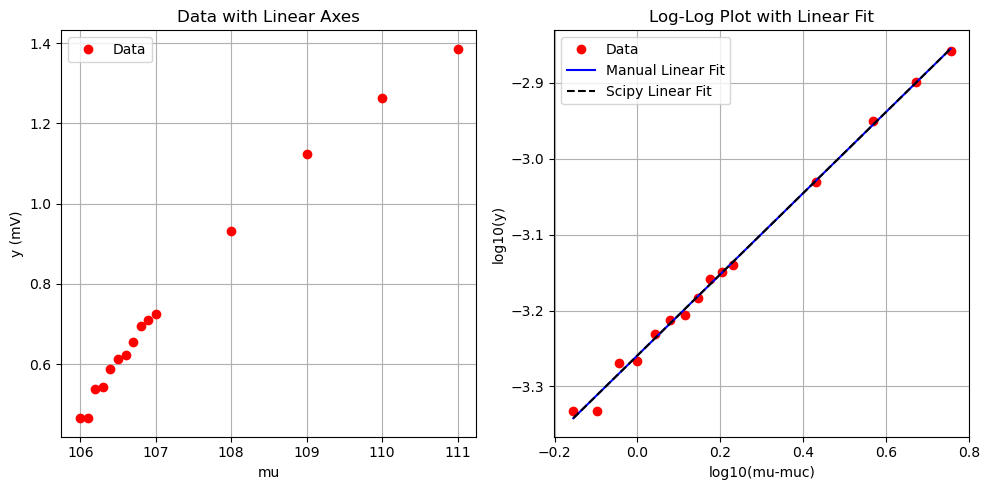

Manual Linear Regression Results:
Slope (beta_estimate_manual): 0.5347071586945512
Intercept (b_estimate_manual): -3.259103213234653
Slope uncertainty (sigma_m_estimate_manual): 0.007992388123672487
Intercept uncertainty (sigma_b_estimate_manual): 0.0027186414607300318

Scipy Linear Regression Results:
Slope (m_stats): 0.5347071586945531
Intercept (b_stats): -3.2591032132346536
p_value: 1.7445773703089328e-17
Standard error: 0.008585202021686866


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import datetime

# Create a time stamp for each run
my_name = "Daniel Mazin"
time_stamp_format = "%Y-%m-%d %H:%M:%S"
print(my_name, datetime.datetime.now().strftime(time_stamp_format), '\n')

# Load data from the file, skip the first row which might contain header
data = np.loadtxt("Nonlinear-Ave-goofy.csv", delimiter=",", skiprows=1) 

# Extract data columns
mudata = data[:, 0] - 105.3  # Subtracting the critical resistance
ydata = data[:, 1] / 1000.0   # Dividing by 1000 to convert from mV to V

# Calculate necessary parameters based on data
Ndata = len(mudata)
logmudata = np.log10(mudata)
logydata = np.log10(ydata)

print (logmudata)

# Perform manual linear regression
logmuav = np.mean(logmudata)
logyav = np.mean(logydata)
logmu2av = np.mean(logmudata ** 2)
logmuyav = np.mean(logmudata * logydata)

m_estimate_manual = (logmuyav - logmuav * logyav) / (logmu2av - logmuav ** 2)
b_estimate_manual = logyav - m_estimate_manual * logmuav

# Calculate the uncertainties of the estimates
residuals_manual = logydata - (m_estimate_manual * logmudata + b_estimate_manual)
sigma_m_estimate_manual = np.std(residuals_manual) / np.sqrt(Ndata * (logmu2av - logmuav ** 2))
sigma_b_estimate_manual = sigma_m_estimate_manual * np.sqrt(logmu2av)

# Perform linear regression using scipy's stats.linregress
m_stats, b_stats, r_value, p_value, std_err = stats.linregress(logmudata, logydata)

# Plot the results
plt.figure(figsize=(10, 5))

# Plot the data with linear axes
plt.subplot(1, 2, 1)
plt.plot(mudata + 105.3, ydata * 1000, 'ro', label='Data')
plt.xlabel('mu')
plt.ylabel('y (mV)')
plt.title('Data with Linear Axes')
plt.legend()
plt.grid(True)

# Plot the log-log data with linear fit line
plt.subplot(1, 2, 2)
plt.plot(logmudata, logydata, 'ro', label='Data')
plt.plot(logmudata, m_estimate_manual * logmudata + b_estimate_manual, 'b-', label='Manual Linear Fit')
plt.plot(logmudata, m_stats * logmudata + b_stats, 'k--', label='Scipy Linear Fit')
plt.xlabel('log10(mu-muc)')
plt.ylabel('log10(y)')
plt.title('Log-Log Plot with Linear Fit')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Output results
print('Manual Linear Regression Results:')
print('Slope (beta_estimate_manual):', m_estimate_manual)
print('Intercept (b_estimate_manual):', b_estimate_manual)
print('Slope uncertainty (sigma_m_estimate_manual):', sigma_m_estimate_manual)
print('Intercept uncertainty (sigma_b_estimate_manual):', sigma_b_estimate_manual)
print('\nScipy Linear Regression Results:')
print('Slope (m_stats):', m_stats)
print('Intercept (b_stats):', b_stats)
print('p_value:', p_value)
print('Standard error:', std_err)

## Appendix - relative sample values

In [27]:
N = 5 # samples per decade
D = 3 # number of decades
Dstart = 1.E-3 # starting decade
Ndata = D*N+1

multiplier = 10**(1./N)

murel = np.zeros(Ndata)
murel[0] = Dstart
print('{0:.3e} '.format(murel[0]),end='')
for i in range(1,Ndata):
    murel[i] = murel[i-1]*multiplier
    print('{0:.3e} '.format(murel[i]),end='')

1.000e-03 1.585e-03 2.512e-03 3.981e-03 6.310e-03 1.000e-02 1.585e-02 2.512e-02 3.981e-02 6.310e-02 1.000e-01 1.585e-01 2.512e-01 3.981e-01 6.310e-01 1.000e+00 